In [1]:
import scipy.io
import os
import numpy as np
import mne
from scipy.stats import pearsonr
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.signal import butter, filtfilt

In [2]:
# Cocktail Party Experiment
# Experiment Information
# Subjects 1-17 were instructed to attend to 'Twenty Thousand Leagues Under the Sea' (20000), played in the left ear
# Subjects 18-33 were instructed to attend to 'Journey to the Centre of the Earth' (Journey), played in the right ear

# score: Comprehension question scores for attended and unattended stories.
# Format: [33 Subjects x 30 Run x Story (Attended, Unattended)]

# eegData: EEG Data, Time Locked to the onset of the speech stimulus.   
# Format: Channels (128) x Time Points
# EEG data is unfiltered, unreferenced and sampled at 128Hz

# mastoids: Mastoid Channels, Time Locked to the onset of the speech stimulus. 
# Format: Channels (Left=1 Right=2) x Time Points

# fs: Sampling Rate 

behav_data = scipy.io.loadmat(r'/Users/lucaswin/COGS189/CocktailParty/Behavioural Data/Comprehension Scores')
eeg_folder_path = r'/Users/lucaswin/COGS189/CocktailParty/EEG'

all_subjects_data = []
all_subjects_eeg = []

subjects_20000 = []
subjects_journey = []

fs = 128

for subj in range(1, 34):
    subj_dir = os.path.join(eeg_folder_path, f'Subject{subj}')
    subj_runs_data = []
    subj_runs_eeg = []
    
    for run in range(1, 31):
        if subj == 6:
            continue
            
        file_name = f'Subject{subj}_Run{run}.mat'
        file_path = os.path.join(subj_dir, file_name)

        try:
            data = scipy.io.loadmat(file_path)

            # Access the data as a numpy array
            eeg_data_run = np.array(data['eegData'])
            mastoids_data_run = np.array(data['mastoids'])

            # Filtering
            low_freq, high_freq = 0.5, 30
            order = 4
            nyq = 0.5 * fs 
            low = low_freq / nyq
            high = high_freq / nyq            
            b, a = butter(order, [low, high], btype='band')
            filtered_data = filtfilt(b, a, eeg_data_run, axis=0)
            
            # Referencing
            mastoids_avg = np.mean(mastoids_data_run, axis=1, keepdims=True)
            filt_ref_data = filtered_data - mastoids_avg 
            
            if filt_ref_data.shape == (7681, 128):
                filt_ref_data = filt_ref_data.T

            score = behav_data['score'][subj-1][run-1]
            subj_runs_data.append({'eegData': filt_ref_data, 'score': score})
            subj_runs_eeg.append(filt_ref_data)

        except FileNotFoundError:
            print(f'File {file_name} not found, skipping...')
            continue

    all_subjects_data.append(subj_runs_data)
    all_subjects_eeg.append(subj_runs_eeg)
    
    if subj <= 17:
        subjects_20000.append(subj_runs_data)
    else:
        subjects_journey.append(subj_runs_data)
print("Done")

File Subject1_Run14.mat not found, skipping...
File Subject10_Run16.mat not found, skipping...
File Subject16_Run2.mat not found, skipping...
File Subject20_Run27.mat not found, skipping...
File Subject22_Run7.mat not found, skipping...
Done


t-value: -4.815425608156913, p-value: 1.707658259004343e-06


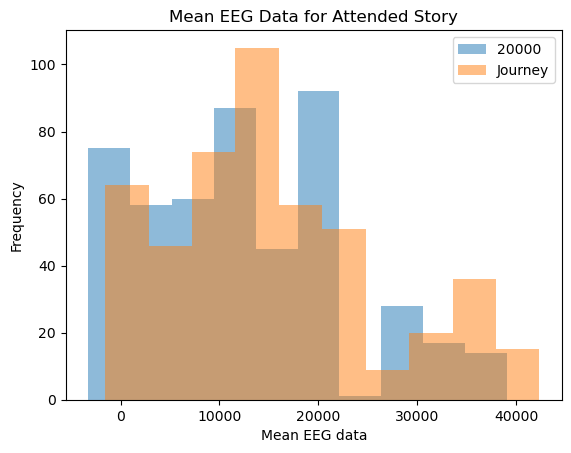

In [4]:
eeg_20000 = [subj['eegData'] for subj_runs_data in subjects_20000 for subj in subj_runs_data]
eeg_journey = [subj['eegData'] for subj_runs_data in subjects_journey for subj in subj_runs_data]

mean_eeg_20000 = [np.mean(eeg_subj) for eeg_subj in eeg_20000]
mean_eeg_journey = [np.mean(eeg_subj) for eeg_subj in eeg_journey]

t_stat, p_val = ttest_ind(mean_eeg_20000, mean_eeg_journey)
print(f"t-value: {t_stat}, p-value: {p_val}")

plt.hist(mean_eeg_20000, alpha=0.5, label='20000')
plt.hist(mean_eeg_journey, alpha=0.5, label='Journey')
plt.legend(loc='upper right')
plt.xlabel('Mean EEG data')
plt.ylabel('Frequency')
plt.title('Mean EEG Data for Attended Story')
plt.show()

t-value: -2.233998684213976, p-value: 0.025706249322019568


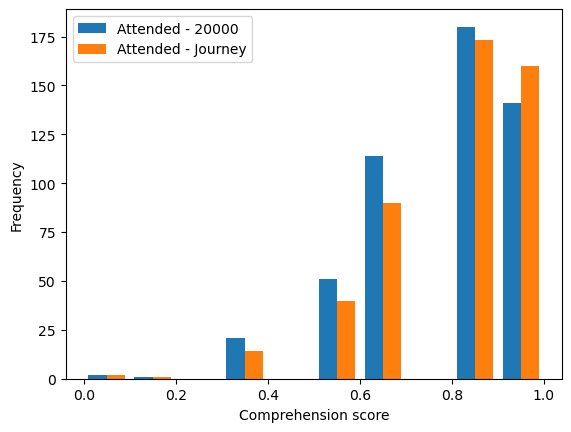

In [5]:
twenty_scores_attended = behav_data['score'][:17, :, 0].flatten() # Extract scores for 20000 story
journey_scores_attended = behav_data['score'][17:, :, 0].flatten() # Extract scores for Journey story

t_stat, p_val = ttest_ind(twenty_scores_attended, journey_scores_attended)
print(f"t-value: {t_stat}, p-value: {p_val}")

plt.hist([twenty_scores_attended, journey_scores_attended], label=['Attended - 20000', 'Attended - Journey'])
plt.legend()
plt.xlabel('Comprehension score')
plt.ylabel('Frequency')
plt.show()

t-value: 0.6961380129239824, p-value: 0.48650612812860694


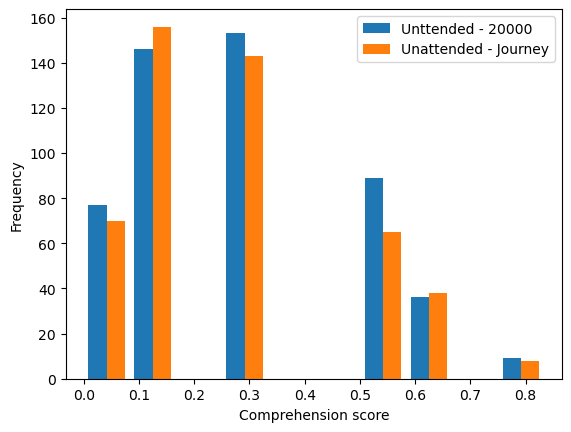

In [6]:
twenty_scores_unattended = behav_data['score'][:17, :, 1].flatten()
journey_scores_unattended = behav_data['score'][17:, :, 1].flatten()

t_stat, p_val = ttest_ind(twenty_scores_unattended, journey_scores_unattended)
print(f"t-value: {t_stat}, p-value: {p_val}")

plt.hist([twenty_scores_unattended, journey_scores_unattended], label=['Unttended - 20000', 'Unattended - Journey'])
plt.legend()
plt.xlabel('Comprehension score')
plt.ylabel('Frequency')
plt.show()